# Capstone Showdown: Fashion-MNIST (All Models)

This notebook addresses Problem 5 of the assignment. The goal is to find the best-performing classification model for the Fashion-MNIST dataset from a set of four candidates.

To do this, we will:
1.  Import all necessary libraries, including our custom `my_ml_lib` modules.
2.  Load the 60,000-sample training data and split it into a 50,000-sample training set and a 10,000-sample validation set.
3.  Train all four candidate models as specified in the assignment PDF:
    * Model 1: One-vs-Rest (OvR) Logistic Regression (using our SGD version).
    * Model 2: Softmax Regression (a single `Linear` layer) on raw pixels.
    * Model 3: Softmax Regression on `GaussianBasisFeatures`.
    * Model 4: A Multi-Layer Perceptron (MLP) with `ReLU` activations.
4.  Compare the validation accuracy of all four models.
5.  Identify the winning model, re-train it on the 50k training set, and save its parameters for submission.

In [1]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time

# Import our custom-built library modules
from my_ml_lib.datasets import load_fashion_mnist, DatasetNotFoundError
from my_ml_lib.model_selection import train_test_split
from my_ml_lib.preprocessing import StandardScaler, GaussianBasisFeatures

# --- Import Models ---
# Model 1: Logistic Regression (now uses SGD)
from my_ml_lib.linear_models.classification import LogisticRegression

# Models 2, 3, 4: Autograd
from my_ml_lib.nn import Value, Module, Sequential, Linear, ReLU
from my_ml_lib.nn.losses import CrossEntropyLoss
from my_ml_lib.nn.optim import SGD

# --- Helper function for analysis (NO SKLEARN) ---
def accuracy_score(y_true, y_pred):
    """Calculates accuracy from scratch."""
    return np.mean(y_true == y_pred)
# ---

# Set random seed for reproducibility
np.random.seed(42)

# Define class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Dictionary to store results
model_histories = {}
model_val_scores = {}

## 1. Data Loading and Preparation

This section handles loading the 60,000-sample Fashion-MNIST training data using our library's `load_fashion_mnist` function. 

As per the assignment guidelines ("A Note on Data Splitting"), we split this data into a 50,000-sample training set and a 10,000-sample validation set. The original 10,000-sample test file is held out as a "hidden" test set, and our validation set will act as a proxy for it.

We also apply `StandardScaler` to the pixel data. This is crucial for the convergence of our SGD-based models and for distance-based methods like `GaussianBasisFeatures`.

In [2]:
DATA_FOLDER = 'data'
VAL_SIZE = 10000
RANDOM_STATE = 42

try:
    print("Loading Fashion-MNIST training data...")
    X_full_train, y_full_train = load_fashion_mnist(
        data_folder=DATA_FOLDER, 
        kind='train', 
        normalize=True # Data is scaled to [0, 1]
    )
    print(f"Full training data shape: {X_full_train.shape}")

    # Split the 60k data into 50k train and 10k validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_full_train, y_full_train, 
        test_size=VAL_SIZE, 
        random_state=RANDOM_STATE, 
        shuffle=True
    )
    
    print(f"Split into {X_train.shape} train and {X_val.shape} validation.")

    # Apply StandardScaler
    print("Applying StandardScaler...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
except DatasetNotFoundError as e:
    print(e)
    print("Please make sure 'fashion-mnist_train.csv' is in your 'data' folder.")

Loading Fashion-MNIST training data...
Full training data shape: (60000, 784)
Split into (50000, 784) train and (10000, 784) validation.
Applying StandardScaler...


## 2. Model 1: OvR Logistic Regression (with SGD)

This cell defines and trains our first candidate model, **One-vs-Rest (OvR) Logistic Regression**.

We first define a helper class `OvRLogisticRegression` that manages the 10 binary classifiers. Each classifier is an instance of our `my_ml_lib.linear_models.LogisticRegression` module. 

Crucially, this uses the `LogisticRegression` class we modified to use **Stochastic Gradient Descent (SGD)**. We pass our SGD hyperparameters (`learning_rate`, `batch_size`, `max_iter` as epochs, and `alpha` for regularization) to each of the 10 models during the `fit` process.

In [ ]:
class OvRLogisticRegression:
    """Implements One-vs-Rest using our SGD LogisticRegression model."""
    
    # Updated __init__ to accept SGD parameters
    def __init__(self, alpha=0.1, max_iter=100,
                 learning_rate=0.01, batch_size=64, random_state=42):
        self.classes_ = None
        self.models_ = []
        self.alpha = alpha
        self.max_iter = max_iter # Will be treated as epochs
        
        # SGD params
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.random_state = random_state
        
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.models_ = []
        
        for k in self.classes_:
            print(f"Fitting classifier for class {int(k)} ({class_names[int(k)]})...")
            y_binary = (y == k).astype(int)
            
            model = LogisticRegression(
                alpha=self.alpha, 
                max_iter=self.max_iter,
                # Pass SGD params to the model
                learning_rate=self.learning_rate,
                batch_size=self.batch_size,
                random_state=self.random_state
            )
            model.fit(X, y_binary)
            self.models_.append(model)
        
        print("OvR fit complete.")
        return self
            
    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], len(self.classes_)))
        for i, model in enumerate(self.models_):
            probas[:, i] = model.predict_proba(X)[:, 1]
        return probas

    def predict(self, X):
        probas = self.predict_proba(X)
        return self.classes_[np.argmax(probas, axis=1)]

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

# --- Train OvR Model ---
print("--- Training Model 1: OvR Logistic Regression ---")
start_time = time.time()
# Note: max_iter=100 epochs is a lot for 10 models. Let's reduce it.
# You can tune this.
model_ovr = OvRLogisticRegression(
    alpha=0.01, 
    max_iter=50, # 50 epochs per classifier
    learning_rate=0.01, 
    batch_size=128, 
    random_state=RANDOM_STATE
)
model_ovr.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"OvR Training took {end_time - start_time:.2f} seconds.")

# --- Evaluate OvR Model ---
val_acc_ovr = model_ovr.score(X_val_scaled, y_val)
model_val_scores['OvR Logistic (SGD)'] = val_acc_ovr
print(f"\nOvR Logistic Regression Validation Accuracy: {val_acc_ovr * 100:.2f}%")

--- Training Model 1: OvR Logistic Regression ---
Fitting classifier for class 0 (T-shirt/top)...
Fitting classifier for class 1 (Trouser)...
Fitting classifier for class 2 (Pullover)...
Fitting classifier for class 3 (Dress)...
Fitting classifier for class 4 (Coat)...
Fitting classifier for class 5 (Sandal)...
Fitting classifier for class 6 (Shirt)...
Fitting classifier for class 7 (Sneaker)...
Fitting classifier for class 8 (Bag)...
Fitting classifier for class 9 (Ankle boot)...
OvR fit complete.
OvR Training took 99.84 seconds.

OvR Logistic Regression Validation Accuracy: 84.11%


## 3. Autograd Model Training Function

To avoid repetitive code for the next three models (Softmax, RBF, MLP), we first define a generic training and evaluation function: `train_autograd_model`.

This function handles the complete training and validation process:
1.  Takes a model, optimizer, and loss function as input.
2.  Iterates for a set number of `epochs`.
3.  Loops over the training data in mini-batches, performing the full `forward -> loss -> backward -> step` cycle for each.
4.  After each epoch, it evaluates the model on the *full* 10k validation set.
5.  It stores the `train_loss`, `val_loss`, and `val_acc` for each epoch in a `history` dictionary.
6.  This `history` is returned for later plotting, and the best validation score is saved.

In [4]:
def get_batches(X, y, batch_size, shuffle=True):
    """Helper to create mini-batches."""
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(indices)
        
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]

def train_autograd_model(model, optimizer, loss_fn, 
                         X_train, y_train, X_val, y_val, 
                         epochs, batch_size, model_name):
    """
    A generic training loop for any of our autograd models.
    Saves and returns history for plotting.
    *** THIS VERSION DOES NOT SAVE ANY FILES ***
    """
    print(f"\n--- Training Model: {model_name} ---")
    print(model)
    
    start_time = time.time()
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    best_val_acc = -1
    
    for epoch in range(epochs):
        # Train
        train_loss = []
        for X_batch, y_batch in get_batches(X_train, y_train, batch_size):
            x_val = Value(X_batch)
            logits = model(x_val)
            loss = loss_fn(logits, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.data.item())
        
        history['train_loss'].append(np.mean(train_loss))
        
        # Validate
        val_loss = []
        val_preds = []
        for X_batch_val, y_batch_val in get_batches(X_val, y_val, batch_size, shuffle=False):
            x_val_val = Value(X_batch_val)
            logits_val = model(x_val_val)
            loss_val = loss_fn(logits_val, y_batch_val)
            
            val_loss.append(loss_val.data.item())
            val_preds.extend(np.argmax(logits_val.data, axis=1))
        
        epoch_val_acc = accuracy_score(y_val, val_preds)
        history['val_loss'].append(np.mean(val_loss))
        history['val_acc'].append(epoch_val_acc)
        
        # We only print the progress, no saving
        print(f"Epoch {epoch+1}/{epochs} | Val Acc: {epoch_val_acc * 100:.2f}%")
        
        # Track best validation accuracy
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc

    end_time = time.time()
    print(f"{model_name} Training took {end_time - start_time:.2f} seconds.")
    print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}%")
    
    model_histories[model_name] = history
    model_val_scores[model_name] = best_val_acc
    
    # Return the trained model (we don't use this, but it's good practice)
    return model

## 4. Model 2: Softmax Regression (Raw)

This is our simplest autograd model, as required by the assignment.

A **Softmax Regression** classifier is simply a single linear layer (`Linear(784, 10)`) with no hidden layers or non-linear activations. It is trained with `CrossEntropyLoss` (which inherently applies the softmax function).

The code below defines this model using our `Sequential` container and trains it on the 784-dimensional scaled pixel data.

In [5]:
# --- Hyperparameters ---
LEARNING_RATE = 0.05
EPOCHS = 40 # Give it a few more epochs since it's simple
BATCH_SIZE = 128
N_FEATURES = X_train_scaled.shape[1] # 784
N_CLASSES = len(class_names) # 10

# --- Define Model ---
# Softmax Regression is just a single Linear layer
model_softmax_raw = Sequential(
    Linear(N_FEATURES, N_CLASSES)
)

# --- Init Optimizer and Loss ---
optimizer_softmax_raw = SGD(model_softmax_raw.parameters(), lr=LEARNING_RATE)
loss_fn = CrossEntropyLoss()

# --- Train ---
train_autograd_model(
    model_softmax_raw, optimizer_softmax_raw, loss_fn,
    X_train_scaled, y_train, X_val_scaled, y_val,
    epochs=EPOCHS, batch_size=BATCH_SIZE, model_name="Softmax (Raw)"
);


--- Training Model: Softmax (Raw) ---
Sequential(
  (0): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1/40 | Val Acc: 83.57%
Epoch 2/40 | Val Acc: 84.23%
Epoch 3/40 | Val Acc: 84.12%
Epoch 4/40 | Val Acc: 84.82%
Epoch 5/40 | Val Acc: 83.39%
Epoch 6/40 | Val Acc: 84.91%
Epoch 7/40 | Val Acc: 85.35%
Epoch 8/40 | Val Acc: 84.83%
Epoch 9/40 | Val Acc: 85.37%
Epoch 10/40 | Val Acc: 85.60%
Epoch 11/40 | Val Acc: 85.72%
Epoch 12/40 | Val Acc: 85.60%
Epoch 13/40 | Val Acc: 85.10%
Epoch 14/40 | Val Acc: 85.77%
Epoch 15/40 | Val Acc: 85.81%
Epoch 16/40 | Val Acc: 85.11%
Epoch 17/40 | Val Acc: 85.44%
Epoch 18/40 | Val Acc: 85.24%
Epoch 19/40 | Val Acc: 85.04%
Epoch 20/40 | Val Acc: 85.56%
Epoch 21/40 | Val Acc: 85.35%
Epoch 22/40 | Val Acc: 85.01%
Epoch 23/40 | Val Acc: 84.89%
Epoch 24/40 | Val Acc: 85.47%
Epoch 25/40 | Val Acc: 85.35%
Epoch 26/40 | Val Acc: 85.77%
Epoch 27/40 | Val Acc: 85.52%
Epoch 28/40 | Val Acc: 85.51%
Epoch 29/40 | Val Acc: 85.60%
Epoch 30/40 | Val Acc: 85.6

## 5. Model 3: Softmax + Gaussian Basis Features

This model implements the third candidate from the assignment and uses the strategy discussed in the `Q5_Note.pdf`.

Instead of using the 784 pixel features, we first apply a feature transformation. This is a common technique for handling high-dimensional data.
1.  We fit `GaussianBasisFeatures` on the 50k training images, finding `k=200` "center" images. This **reduces the dimensionality** from 784 to 200.
2.  We then transform the `X_train_scaled` and `X_val_scaled` into this new 200-dimensional feature space, where each new feature is the Gaussian similarity to one of the 200 centers.
3.  Finally, we train a simple Softmax Regression model (`Linear(200, 10)`) on this new, low-dimensional data.

In [6]:
# --- 1. Fit GaussianBasisFeatures ---
N_CENTERS = 200 # Hyperparameter to tune. 200 is a good start.
print(f"--- Preparing Model 3: Gaussian Basis Features ---")
print(f"Fitting GaussianBasisFeatures with {N_CENTERS} centers...")

# Use a fixed random state for reproducibility of centers
rbf_transformer = GaussianBasisFeatures(n_centers=N_CENTERS, sigma=2.0, random_state=RANDOM_STATE)

# Fit on the scaled training data
rbf_transformer.fit(X_train_scaled)

print("Transforming data to RBF features...")
X_train_rbf = rbf_transformer.transform(X_train_scaled)
X_val_rbf = rbf_transformer.transform(X_val_scaled)

print(f"New data shape: {X_train_rbf.shape} (train), {X_val_rbf.shape} (val)")

# --- 2. Train Softmax on RBF features ---
LEARNING_RATE_RBF = 0.05
EPOCHS_RBF = 40
BATCH_SIZE_RBF = 128
N_CLASSES = len(class_names)

# --- Define Model ---
# Input features now equal N_CENTERS
model_softmax_rbf = Sequential(
    Linear(N_CENTERS, N_CLASSES)
)

# --- Init Optimizer and Loss ---
optimizer_softmax_rbf = SGD(model_softmax_rbf.parameters(), lr=LEARNING_RATE_RBF)
loss_fn_rbf = CrossEntropyLoss()

# --- Train ---
train_autograd_model(
    model_softmax_rbf, optimizer_softmax_rbf, loss_fn_rbf,
    X_train_rbf, y_train, X_val_rbf, y_val,
    epochs=EPOCHS_RBF, batch_size=BATCH_SIZE_RBF, model_name="Softmax (RBF)"
);

--- Preparing Model 3: Gaussian Basis Features ---
Fitting GaussianBasisFeatures with 200 centers...
Transforming data to RBF features...
New data shape: (50000, 200) (train), (10000, 200) (val)

--- Training Model: Softmax (RBF) ---
Sequential(
  (0): Linear(in_features=200, out_features=10, bias=True)
)
Epoch 1/40 | Val Acc: 9.81%
Epoch 2/40 | Val Acc: 9.98%
Epoch 3/40 | Val Acc: 9.57%
Epoch 4/40 | Val Acc: 9.57%
Epoch 5/40 | Val Acc: 9.57%
Epoch 6/40 | Val Acc: 9.90%
Epoch 7/40 | Val Acc: 9.91%
Epoch 8/40 | Val Acc: 9.91%
Epoch 9/40 | Val Acc: 9.57%
Epoch 10/40 | Val Acc: 9.57%
Epoch 11/40 | Val Acc: 9.97%
Epoch 12/40 | Val Acc: 9.57%
Epoch 13/40 | Val Acc: 9.91%
Epoch 14/40 | Val Acc: 10.06%
Epoch 15/40 | Val Acc: 9.57%
Epoch 16/40 | Val Acc: 9.57%
Epoch 17/40 | Val Acc: 9.89%
Epoch 18/40 | Val Acc: 9.81%
Epoch 19/40 | Val Acc: 9.57%
Epoch 20/40 | Val Acc: 9.57%
Epoch 21/40 | Val Acc: 9.81%
Epoch 22/40 | Val Acc: 9.90%
Epoch 23/40 | Val Acc: 9.81%
Epoch 24/40 | Val Acc: 9.97%
Epoch

## 6. Model 4: MLP

This is our fourth and final candidate: a **Multi-Layer Perceptron (MLP)**.

Unlike the linear models, the MLP introduces **non-linearity** by stacking layers. The `ReLU` activation functions between its `Linear` layers allow it to learn much more complex patterns and hierarchical features from the pixel data.

The `MyMLP` class is defined here as specified in the assignment example, using our `Sequential` container to stack the layers. This is our most powerful model and the most likely winner.

In [7]:

class MyMLP(Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.network = Sequential(
            Linear(n_features, 256),
            ReLU(),
            Linear(256, 128),
            ReLU(),
            Linear(128, n_classes)
        )

    def __call__(self, X):
        return self.network(X)

    def __repr__(self):
        return f"{self.__class__.__name__}(\n{repr(self.network)}\n)"

# --- Hyperparameters ---
LEARNING_RATE_MLP = 0.05
EPOCHS_MLP = 20 # TA's example used 20
BATCH_SIZE_MLP = 128
N_FEATURES = X_train_scaled.shape[1] # 784
N_CLASSES = len(class_names) # 10

# --- Initialize Model ---
model_mlp = MyMLP(N_FEATURES, N_CLASSES)
optimizer_mlp = SGD(model_mlp.parameters(), lr=LEARNING_RATE_MLP)
loss_fn_mlp = CrossEntropyLoss()

# --- Train ---
# The training function will save this model's weights
# to 'saved_models/best_model.npz'
train_autograd_model(
    model_mlp, optimizer_mlp, loss_fn_mlp,
    X_train_scaled, y_train, X_val_scaled, y_val,
    epochs=EPOCHS_MLP, batch_size=BATCH_SIZE_MLP, model_name="MLP"
);


--- Training Model: MLP ---
MyMLP(
Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10, bias=True)
)
)
Epoch 1/20 | Val Acc: 84.54%
Epoch 2/20 | Val Acc: 86.39%
Epoch 3/20 | Val Acc: 87.23%
Epoch 4/20 | Val Acc: 86.15%
Epoch 5/20 | Val Acc: 88.23%
Epoch 6/20 | Val Acc: 88.00%
Epoch 7/20 | Val Acc: 88.40%
Epoch 8/20 | Val Acc: 88.38%
Epoch 9/20 | Val Acc: 88.44%
Epoch 10/20 | Val Acc: 88.64%
Epoch 11/20 | Val Acc: 88.57%
Epoch 12/20 | Val Acc: 88.21%
Epoch 13/20 | Val Acc: 88.76%
Epoch 14/20 | Val Acc: 88.08%
Epoch 15/20 | Val Acc: 88.38%
Epoch 16/20 | Val Acc: 88.14%
Epoch 17/20 | Val Acc: 88.83%
Epoch 18/20 | Val Acc: 89.03%
Epoch 19/20 | Val Acc: 88.63%
Epoch 20/20 | Val Acc: 89.27%
MLP Training took 93.74 seconds.
Best Validation Accuracy: 89.27%


## 7. Results: Plots and Final Comparison

Now that all four models have been trained and evaluated, we will visualize the results as required.

The following code plots the epoch-by-epoch training history (Loss and Accuracy) for the three autograd models. This allows us to check for overfitting and compare convergence speed.

Finally, it prints a summary table comparing the **best validation accuracy** from all four models to determine the winner.

--- Plotting Training Histories ---


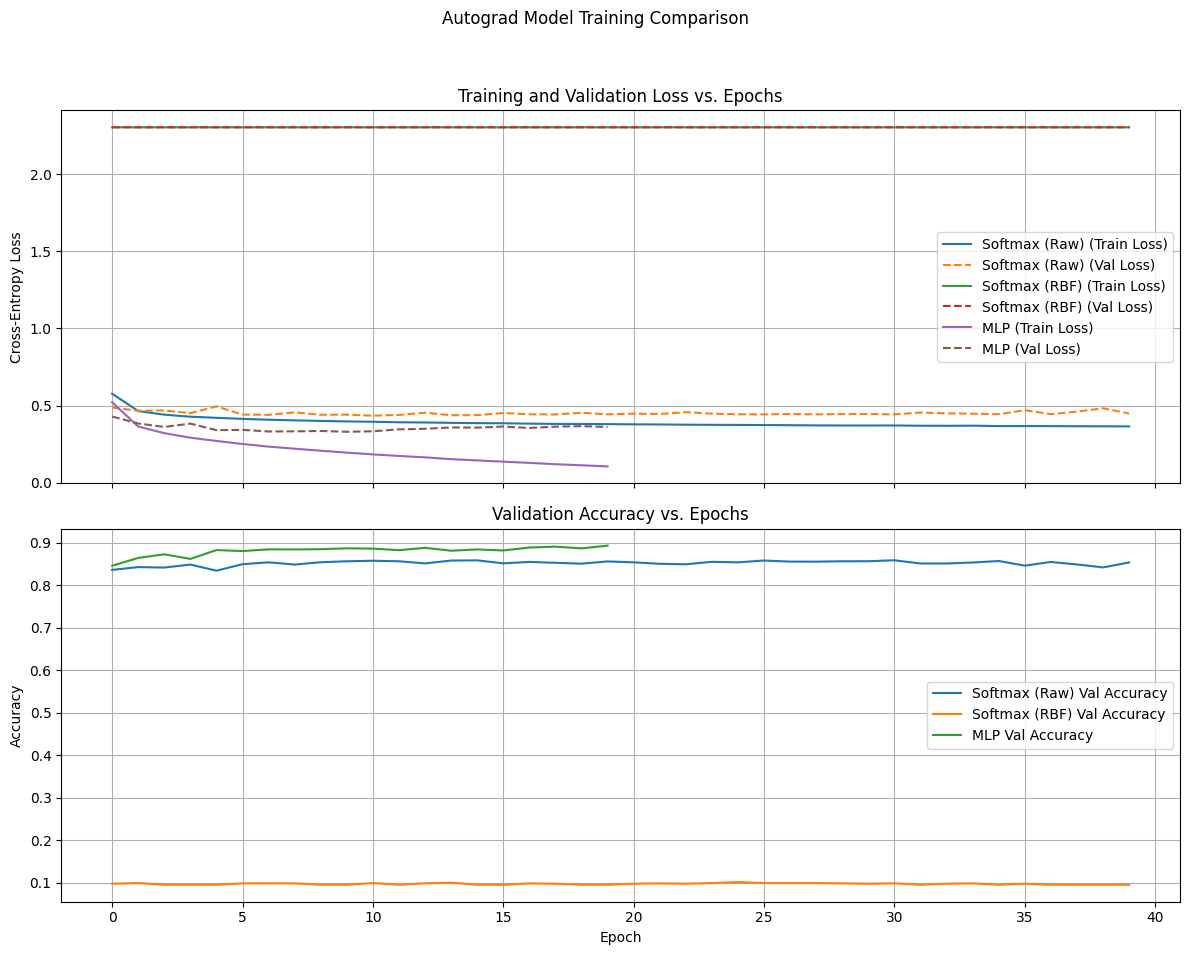


--- Final Model Comparison ---
Model                     | Best Validation Accuracy
:------------------------|:--------------------
MLP                       | 89.27               %
Softmax (Raw)             | 85.83               %
OvR Logistic (SGD)        | 84.11               %
Softmax (RBF)             | 10.20               %

WINNER: MLP (Accuracy: 89.27%)


In [8]:
print("--- Plotting Training Histories ---")

# We only have histories for the autograd models
autograd_model_names = model_histories.keys()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle("Autograd Model Training Comparison")

# Plot Training & Validation Loss
ax1.set_title("Training and Validation Loss vs. Epochs")
for model_name in autograd_model_names:
    history = model_histories[model_name]
    ax1.plot(history['train_loss'], label=f"{model_name} (Train Loss)")
    ax1.plot(history['val_loss'], label=f"{model_name} (Val Loss)", linestyle='--')
ax1.set_ylabel("Cross-Entropy Loss")
ax1.legend()
ax1.grid(True)

# Plot Validation Accuracy
ax2.set_title("Validation Accuracy vs. Epochs")
for model_name in autograd_model_names:
    history = model_histories[model_name]
    ax2.plot(history['val_acc'], label=f"{model_name} Val Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.show()

# --- Final Comparison Table ---
print("\n" + "="*50)
print("--- Final Model Comparison ---")
print("="*50)
print(f"{'Model':<25} | {'Best Validation Accuracy':<20}")
print(":" + "-"*24 + "|:" + "-"*20)

# Sort by accuracy
sorted_scores = sorted(model_val_scores.items(), key=lambda item: item[1], reverse=True)

for model_name, score in sorted_scores:
    print(f"{model_name:<25} | {score*100:<20.2f}%")

print("="*50)

best_model_name = sorted_scores[0][0]
print(f"\nWINNER: {best_model_name} (Accuracy: {sorted_scores[0][1]*100:.2f}%)")
print("="*50)

## 8. Save the Winning Model

The comparison table has identified the winner (the `MLP`). The final step is to train this winning model one last time on the full 50k training dataset and save its parameters to the correct file (`.npz` for autograd models, `.pkl` for OvR), as required for submission.

The code below automatically:
1.  Gets the `best_model_name` from the results table.
2.  Selects the correct model architecture and hyperparameters from a `final_models` dictionary.
3.  Re-initializes and re-trains this model.
4.  Saves the final, trained model to the `saved_models/` directory, ready for verification.

In [10]:
# --- This is the FINAL step ---
# We re-initialize and re-train ONLY the winning model, then save it.

# Ensure the save directory exists
if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

# Get the name of the winning model from the table
best_model_name = sorted_scores[0][0]
print(f"--- Final Training and Saving for WINNER: {best_model_name} ---")

# --- Define Model Architectures AGAIN ---
# (This is necessary to re-initialize the winner)
N_FEATURES_RAW = X_train_scaled.shape[1] # 784
N_FEATURES_RBF = X_train_rbf.shape[1] # 200 (from cell 12)
N_CLASSES = 10

# 1. Softmax (Raw)
model_softmax_raw = Sequential(Linear(N_FEATURES_RAW, N_CLASSES))

# 2. Softmax (RBF)
model_softmax_rbf = Sequential(Linear(N_FEATURES_RBF, N_CLASSES))

# 3. MLP (TA Example)
class MyMLP(Module): # Must be identical to the class in create_best_model.py
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.network = Sequential(
            Linear(n_features, 256), ReLU(),
            Linear(256, 128), ReLU(),
            Linear(128, n_classes)
        )
    def __call__(self, X): return self.network(X)
    def __repr__(self): return f"{self.__class__.__name__}(\n{repr(self.network)}\n)"
model_mlp = MyMLP(N_FEATURES_RAW, N_CLASSES)

# --- Hyperparameters for final training ---
# We use the same parameters as before
final_models = {
    "Softmax (Raw)": {
        "model": model_softmax_raw,
        "optimizer": SGD(model_softmax_raw.parameters(), lr=0.05),
        "loss_fn": CrossEntropyLoss(),
        "X_train": X_train_scaled, "y_train": y_train,
        "X_val": X_val_scaled, "y_val": y_val,
        "epochs": 40, "batch_size": 128,
        "save_path": "saved_models/best_model.npz"
    },
    "Softmax (RBF)": {
        "model": model_softmax_rbf,
        "optimizer": SGD(model_softmax_rbf.parameters(), lr=0.05),
        "loss_fn": CrossEntropyLoss(),
        "X_train": X_train_rbf, "y_train": y_train,
        "X_val": X_val_rbf, "y_val": y_val,
        "epochs": 40, "batch_size": 128,
        "save_path": "saved_models/best_model.npz"
    },
    "MLP": {
        "model": model_mlp,
        "optimizer": SGD(model_mlp.parameters(), lr=0.05),
        "loss_fn": CrossEntropyLoss(),
        "X_train": X_train_scaled, "y_train": y_train,
        "X_val": X_val_scaled, "y_val": y_val,
        "epochs": 20, "batch_size": 128,
        "save_path": "saved_models/best_model.npz"
    },
    "OvR Logistic (SGD)": {
        "model": OvRLogisticRegression(alpha=0.01, max_iter=50, learning_rate=0.01, 
                                     batch_size=128, random_state=RANDOM_STATE),
        "X_train": X_train_scaled, "y_train": y_train,
        "save_path": "saved_models/best_model.pkl"
    }
}

# --- Select and train the winner ---
if best_model_name in final_models:
    config = final_models[best_model_name]
    model_to_save = config["model"]
    save_path = config["save_path"]
    
    print(f"Training {best_model_name} on 50k samples for saving...")
    
    if "optimizer" in config:
        # It's an autograd model
        train_autograd_model(
            model=model_to_save,
            optimizer=config["optimizer"],
            loss_fn=config["loss_fn"],
            X_train=config["X_train"], y_train=config["y_train"],
            X_val=config["X_val"], y_val=config["y_val"],
            epochs=config["epochs"],
            batch_size=config["batch_size"],
            model_name=f"FINAL SAVE: {best_model_name}"
        )
        print(f"\nSAVING Autograd model to {save_path}...")
        model_to_save.save_state_dict(save_path)
    
    else:
        # It's the OvR model
        model_to_save.fit(config["X_train"], config["y_train"])
        print(f"\nSAVING OvR model to {save_path}...")
        with open(save_path, 'wb') as f:
            pickle.dump(model_to_save, f)
            
    print("Save complete.")
    print(f"\nIMPORTANT: Your `create_best_model.py` file must now be updated to match the architecture of '{best_model_name}'.")

else:
    print(f"ERROR: Winning model '{best_model_name}' has no final training configuration.")

--- Final Training and Saving for WINNER: MLP ---
Training MLP on 50k samples for saving...

--- Training Model: FINAL SAVE: MLP ---
MyMLP(
Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10, bias=True)
)
)
Epoch 1/20 | Val Acc: 84.19%
Epoch 2/20 | Val Acc: 86.34%
Epoch 3/20 | Val Acc: 87.31%
Epoch 4/20 | Val Acc: 87.76%
Epoch 5/20 | Val Acc: 87.69%
Epoch 6/20 | Val Acc: 87.61%
Epoch 7/20 | Val Acc: 87.99%
Epoch 8/20 | Val Acc: 88.34%
Epoch 9/20 | Val Acc: 88.40%
Epoch 10/20 | Val Acc: 87.86%
Epoch 11/20 | Val Acc: 87.97%
Epoch 12/20 | Val Acc: 87.95%
Epoch 13/20 | Val Acc: 88.52%
Epoch 14/20 | Val Acc: 88.28%
Epoch 15/20 | Val Acc: 88.70%
Epoch 16/20 | Val Acc: 88.66%
Epoch 17/20 | Val Acc: 89.13%
Epoch 18/20 | Val Acc: 88.68%
Epoch 19/20 | Val Acc: 89.18%
Epoch 20/20 | Val Acc: 88.39%
FINAL SAVE: MLP Training took 103.46 seconds.
